In [155]:
# 1 - DATA MANIPULATION
import pandas as pd
import numpy as np

# 2 - DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# 3 - DATA EXPLORATION
from ydata_profiling import ProfileReport

# 4 - FEATURE ENGINEERING AND PREPROCESSING
import string #punctuation
import textstat

import nltk #English language stopwords
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

import spacy
nlp = spacy.load("en_core_web_sm")

from lexicalrichness import LexicalRichness

import re

from tensorflow.keras.preprocessing.text import text_to_word_sequence


# 5 - MODEL
#SKLEARN METRICS
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline



from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import models
from tensorflow.keras.utils import plot_model


In [156]:
df = pd.read_csv('/Users/andreacalcagni/code/AndreaCalcagni/neuroCraft/raw_data/CLEAR Corpus 6.01 - CLEAR Corpus 6.01.csv')


In [157]:
df = df.drop(columns=['Last Changed', 'URL', 'Anthology', 'MPAA \n#Max', 'Pub Year', 'MPAA\n#Avg', 'License', 'British Words', 'firstPlace_pred', 'secondPlace_pred', 'thirdPlace_pred',
       'fourthPlace_pred', 'fifthPlace_pred', 'sixthPlace_pred', 'ID', 'Author', 'Title', 'Source', 'Category', 'Location', 'MPAA\nMax', 'BT s.e.', 'Kaggle split'])


# 1. Feature Engineering

## 1.1 Text-Based Features

### 1.1.1. Word Count

In [158]:
def avg_word_count(row):
    return row[['Joon\nWC v1', 'Google\nWC']].mean()

# Create a new column
df['Avg Word Count'] = df.apply(avg_word_count, axis=1)
df = df.drop(columns=['Joon\nWC v1', 'Google\nWC'])


### 1.1.2 Unique Word Count

In [159]:
def count_unique_words(row):
    words = row['Excerpt'].split()
    return len(set(words))

df['Unique Word Count'] = df.apply(count_unique_words, axis=1)


### 1.1.3 Word Lenght

In [160]:
def avg_word_length(x):
    punctuation = string.punctuation
    for punc in punctuation:
        x = x.replace(punc,' ')
    words = x.split(' ')
    words = [word for word in words if len(word) > 0]
    word_len = [len(word) for word in words]
    return np.mean(word_len)

# New column 'Avg Word Length'
df['Avg Word Length'] = df['Excerpt'].apply(avg_word_length)


### 1.1.4 Sentence Count

In [161]:
def calculate_average_sentence_count(row):
    sentence_count_columns = ['Sentence\nCount v1', 'Sentence\nCount v2']
    return row[sentence_count_columns].mean()

# new column
df['Average Sentence Count'] = df.apply(calculate_average_sentence_count, axis=1)
df= df.drop(columns=['Sentence\nCount v1', 'Sentence\nCount v2'])


## 1.2 Complexity Features

### 1.2.1 Average Syllaba per Word

In [162]:
def avg_syllaba_word(x):
    syll_count = [textstat.syllable_count(word) for word in x.split()]
    return np.mean(syll_count)

df['Avg Syllables Per Word'] = df['Excerpt'].apply(avg_syllaba_word)


### 1.2.2 Avg Vowels per Word

In [163]:
def count_vowels(word):
    vowels = set("AEIOUaeiou")
    return sum(1 for char in word if char in vowels)

# New columns:
df['Avg Vowel Count Per Word'] = df['Excerpt'].apply(lambda x: np.mean([count_vowels(word) for word in x.split()]) if x else 0)
df['Total Vowels Per Excerpt'] = df['Excerpt'].apply(lambda x: sum(count_vowels(word) for word in x.split()) if x else 0)
df['Avg Vowels Per Excerpt'] = df['Total Vowels Per Excerpt']/df['Avg Word Count']
df = df.drop(columns=['Total Vowels Per Excerpt'])


### 1.2.3 Punctuation Ratio

In [164]:
def count_punctuation(x):
    punc = string.punctuation
    count=0

    for char in x:
        if char in punc:
            count+=1

    return count/ len(x)

df['punctuation_ratio'] = df['Excerpt'].apply(count_punctuation)


## 1.3 Structural Features

### 1.3.1 Average Sentence Lenght

In [165]:
def count_characters_per_sentence(excerpt):
    # Tokenize the text into sentences
    sentences = sent_tokenize(excerpt)

    # Count the number of characters in each sentence
    char_counts_per_sentence = [len(sentence) for sentence in sentences]

    return char_counts_per_sentence

df['Characters Per Sentence'] = df['Excerpt'].apply(count_characters_per_sentence)

def avg_chars_per_sentence(row):
    # Sum of character counts in all sentences
    total_chars = sum(row['Characters Per Sentence'])

    # Sum of sentence counts from both columns
    total_sentences = row['Average Sentence Count']

    # Calculate average characters per sentence
    return total_chars / total_sentences if total_sentences > 0 else 0

df['Avg Characters per Sentence'] = df.apply(avg_chars_per_sentence, axis=1)
df = df.drop(columns=['Characters Per Sentence'])


### 1.3.2 Ratio of Capital Letters

In [166]:
def ratio_capital_chars(excerpt):
    count = 0
    for char in excerpt:
        if char.isupper():
            count += 1
    return count/len(excerpt)

# new column
df['Capital Char Count'] = df['Excerpt'].apply(ratio_capital_chars)


In [167]:
def count_capital_words(excerpt):
    return sum(1 for word in excerpt.split() if word.isupper() and word.isalpha())

# new column
df['Capital Word Count'] = df['Excerpt'].apply(count_capital_words)
df['Ratio_capital_words'] = df['Capital Word Count']/df['Avg Word Count']
df = df.drop(columns=['Capital Word Count'])


## 1.4 Statistical Features

### 1.4.1 Std of Word Lenght

In [168]:
def word_length_std(excerpt):
    word_lengths = [len(word) for word in excerpt.split()]
    return np.std(word_lengths) if len(word_lengths) > 0 else 0

# New column 'Word Length Std'
df['Word Length Std'] = df['Excerpt'].apply(word_length_std)


### 1.4.2 Std of Sentence Lenght

In [169]:
def sentence_length_variation(row):
    sentence_lengths = count_characters_per_sentence(row['Excerpt'])
    return np.std(sentence_lengths)

df['Sentence Length Variation'] = df.apply(sentence_length_variation, axis=1)


## 1.5 Syntactic Complexity Features (NLP approach)

### 1.5.1 Avg sentence len in words

In [170]:
def sentence_len(x):

    x = x.replace("?",'.').replace("!",'.')

    sentences = x.split('.')

    sentences = [sentence for sentence in sentences if len(sentence) > 0]

    sent_len = [len(sentence.split()) for sentence in sentences]

    return np.mean(sent_len)

df['avg_sentence_len_words'] = df['Excerpt'].apply(sentence_len)


### 1.5.2 Number of clauses per sentence

In [171]:
# Function to calculate the number of clauses per sentence

# # Function to perform POS tagging and count occurrences of each POS
# def pos_distribution(excerpt):
#     # Parse the text using spaCy
#     doc = nlp(excerpt)
#     # Count the occurrences of each POS
#     pos_counts = Counter(token.pos_ for token in doc)
#     return pos_counts


# # Apply functions to create new columns
# df['Num Clauses Per Sentence'] = df['Excerpt'].apply(num_clauses_per_sentence_nlp)

# df['POS Distribution'] = df['Excerpt'].apply(pos_distribution)


In [172]:
# Function to calculate the number of clauses per sentence
# def num_clauses_per_sentence_nlp(excerpt):
#     # Parse the text using spaCy
#     doc = nlp(excerpt)
#     # Count the number of clauses (sentences) in the parsed document
#     num_clauses = len(list(doc.sents))
#     return num_clauses

# df['Num Clauses Per Sentence'] = df['Excerpt'].apply(num_clauses_per_sentence_nlp)


## 1.6 Lexical Diversity

In [173]:
def add_lexical_richness_features(df):
    cttr_list, msttr_list, mtld_list, yule_k_list = [], [], [], []

    for text in df['Excerpt']:
        lex = LexicalRichness(text)
        cttr_list.append(lex.cttr)
        msttr_list.append(lex.msttr(segment_window=25))  # Adjust the segment_window as needed
        mtld_list.append(lex.mtld(threshold=0.72))  # Adjust the threshold as needed
        yule_k_list.append(lex.yulek)

    df['cttr'] = cttr_list
    df['msttr'] = msttr_list
    df['mtld'] = mtld_list
    df['yule_k'] = yule_k_list

# Add lexical richness features to the DataFrame
add_lexical_richness_features(df)


In [174]:
# lexical_columns = ['cttr', 'msttr', 'mtld', 'yule_k']

# # new DataFrame with only the selected columns
# lexical_df = df[lexical_columns]

# # Calculate the correlation matrix
# correlation_matrix = lexical_df.corr()

# # Plot a heatmap of the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title("Correlation Matrix of Lexical Richness Features")
# plt.show()


# 2. Discretizing Target

In [175]:
# Calculating quantiles for bin edges - 7 edges for 6 bins
quantiles = df['BT Easiness'].quantile([0, 0.1667, 0.3333, 0.5, 0.6667, 0.8333, 1]).tolist()


In [176]:
# Correct number of labels for 6 bins
labels_dict = {'very hard':0, 'hard':1, 'moderately hard':2, 'acceptable':3, 'easy':4, 'very easy':5}

# Using 'quantiles' for bins and including 6 labels
df['BT Easiness'] = pd.cut(
    x=df['BT Easiness'],
    bins=quantiles,
    labels=labels_dict.values(),
    include_lowest=True
)


# 3. Train Test Split

In [177]:
X = df.drop(columns=['BT Easiness'])
y = df['BT Easiness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 4. Dummy Baseline Model

In [178]:
y_pred = y_train.value_counts().idxmax()
y_pred = np.full(y_test.shape, y_pred)

accuracy_baseline = accuracy_score(y_test, y_pred)
accuracy_baseline


0.152327221438646

# 5. NLP Model

## 5.1 Text Preprocessing

In [179]:
X_train_text = X_train['Excerpt'].values
X_test_text = X_test['Excerpt'].values


### 5.1.1 Basic Cleaning

In [180]:
def basic_cleaning(sentence):
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())

    # Adding special quotes to the regular expression pattern
    special_quotes = '“”‘’'
    pattern = '[' + re.escape(string.punctuation + special_quotes) + ']'

    sentence = re.sub(pattern, '', sentence)
    sentence = sentence.strip()

    return sentence


In [181]:
X_train_text = [basic_cleaning(sentence) for sentence in X_train_text]
X_test_text = [basic_cleaning(sentence) for sentence in X_test_text]


### 5.1.2 Tokenizing

In [182]:
def tokenizer(sentence):
    return text_to_word_sequence(sentence)


In [183]:
#tokenizing
X_train_text = [tokenizer(sentence) for sentence in X_train_text]
X_test_text = [tokenizer(sentence) for sentence in X_test_text]


### 5.1.3 Lemmatizing

In [184]:
def lemmatizer(sentence):
    wnl = WordNetLemmatizer()
    verbs_lemmatized = []
    for word in sentence:
        verbs_lemmatized.append(wnl.lemmatize(word, pos = 'v'))
    nouns_lemmatized = []
    for word in verbs_lemmatized:
        nouns_lemmatized.append(wnl.lemmatize(word, pos = 'n'))
    adverbs_lemmatized = []
    for word in nouns_lemmatized:
        adverbs_lemmatized.append(wnl.lemmatize(word, pos = 'r'))
    adj_lemmatized = []
    for word in adverbs_lemmatized:
        adj_lemmatized.append(wnl.lemmatize(word, pos = 'a'))
    sat_lemmatized = []
    for word in adj_lemmatized:
        sat_lemmatized.append(wnl.lemmatize(word, pos = 'a'))
    return sat_lemmatized


In [185]:
X_train_text = [lemmatizer(sentence) for sentence in X_train_text]
X_test_text = [lemmatizer(sentence) for sentence in X_test_text]


### 5.1.4 Removing Stopwords

In [186]:
def removing_stopwords(sentence):
    stop_words = set(stopwords.words('english'))
    sentence_new = [w for w in sentence if not w in stop_words]
    return sentence_new

X_train_text = [removing_stopwords(sentence) for sentence in X_train_text]
X_test_text = [removing_stopwords(sentence) for sentence in X_test_text]


### 5.1.5 Creating Embeddings

In [187]:
word2vec = Word2Vec(sentences=X_train_text, min_count=10)

def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])

    return np.array(embedded_sentence)

def embedding(word2vec, sentences):
    embed = []

    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)

    return embed

X_train_text = embedding(word2vec, X_train_text)
X_test_text = embedding(word2vec, X_test_text)


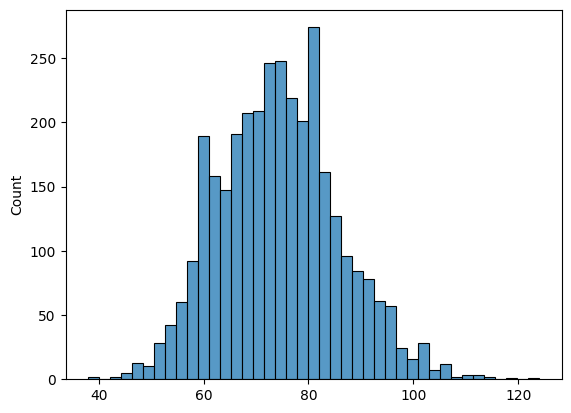

In [188]:
sns.histplot([len(x) for x in X_train_text]);


In [189]:
maxlen=105

X_train_pad = pad_sequences(X_train_text, dtype=float, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_text, dtype=float, padding='post', maxlen=maxlen)


## 5.2 Model Training

In [201]:
def build_model_nlp():
    model = Sequential([
        # layers.Conv1D(105, kernel_size=15, padding='same', activation="relu", input_shape=X_train_pad.shape[1:]),
        # layers.Conv1D(64, kernel_size=10, padding='same', activation="relu"),
        # layers.Flatten(),
        layers.LSTM(105, input_shape=X_train_pad.shape[1:]),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(6, activation='softmax'),
    ])

    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
    return model

model_nlp = build_model_nlp()
model_nlp.summary()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 105)               86520     
                                                                 
 dense_53 (Dense)            (None, 64)                6784      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 6)                 390       
                                                                 
Total params: 93694 (365.99 KB)
Trainable params: 93694 (365.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [202]:
es = EarlyStopping(patience=10, restore_best_weights=True)

model_nlp = build_model_nlp()
model_nlp.fit(X_train_pad, y_train,
          validation_split=0.3,
          epochs=50,
          batch_size=32,
          callbacks=[es]
          )


Epoch 1/50
73/73 [==============================] - 4s 45ms/step - loss: 1.7646 - accuracy: 0.2126 - val_loss: 1.6920 - val_accuracy: 0.2702
Epoch 2/50
73/73 [==============================] - 3s 42ms/step - loss: 1.6828 - accuracy: 0.2649 - val_loss: 1.6509 - val_accuracy: 0.2792
Epoch 3/50
73/73 [==============================] - 3s 41ms/step - loss: 1.6697 - accuracy: 0.2627 - val_loss: 1.6465 - val_accuracy: 0.2812
Epoch 4/50
73/73 [==============================] - 3s 41ms/step - loss: 1.6573 - accuracy: 0.2662 - val_loss: 1.6579 - val_accuracy: 0.2661
Epoch 5/50
73/73 [==============================] - 3s 41ms/step - loss: 1.6684 - accuracy: 0.2615 - val_loss: 1.7678 - val_accuracy: 0.2752
Epoch 6/50
73/73 [==============================] - 3s 44ms/step - loss: 1.6746 - accuracy: 0.2662 - val_loss: 1.6447 - val_accuracy: 0.2762
Epoch 7/50
73/73 [==============================] - 3s 41ms/step - loss: 1.6520 - accuracy: 0.2731 - val_loss: 1.6332 - val_accuracy: 0.2631
Epoch 8/50
73

## 5.3 Model Evaluation

In [203]:
loss, accuracy = model_nlp.evaluate(X_test_pad, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


45/45 [==============================] - 1s 13ms/step - loss: 1.5984 - accuracy: 0.3173
Test loss: 1.5984
Test accuracy: 0.3173


In [204]:
predictions = model_nlp.predict(X_test_pad)

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)


45/45 [==============================] - 1s 12ms/step


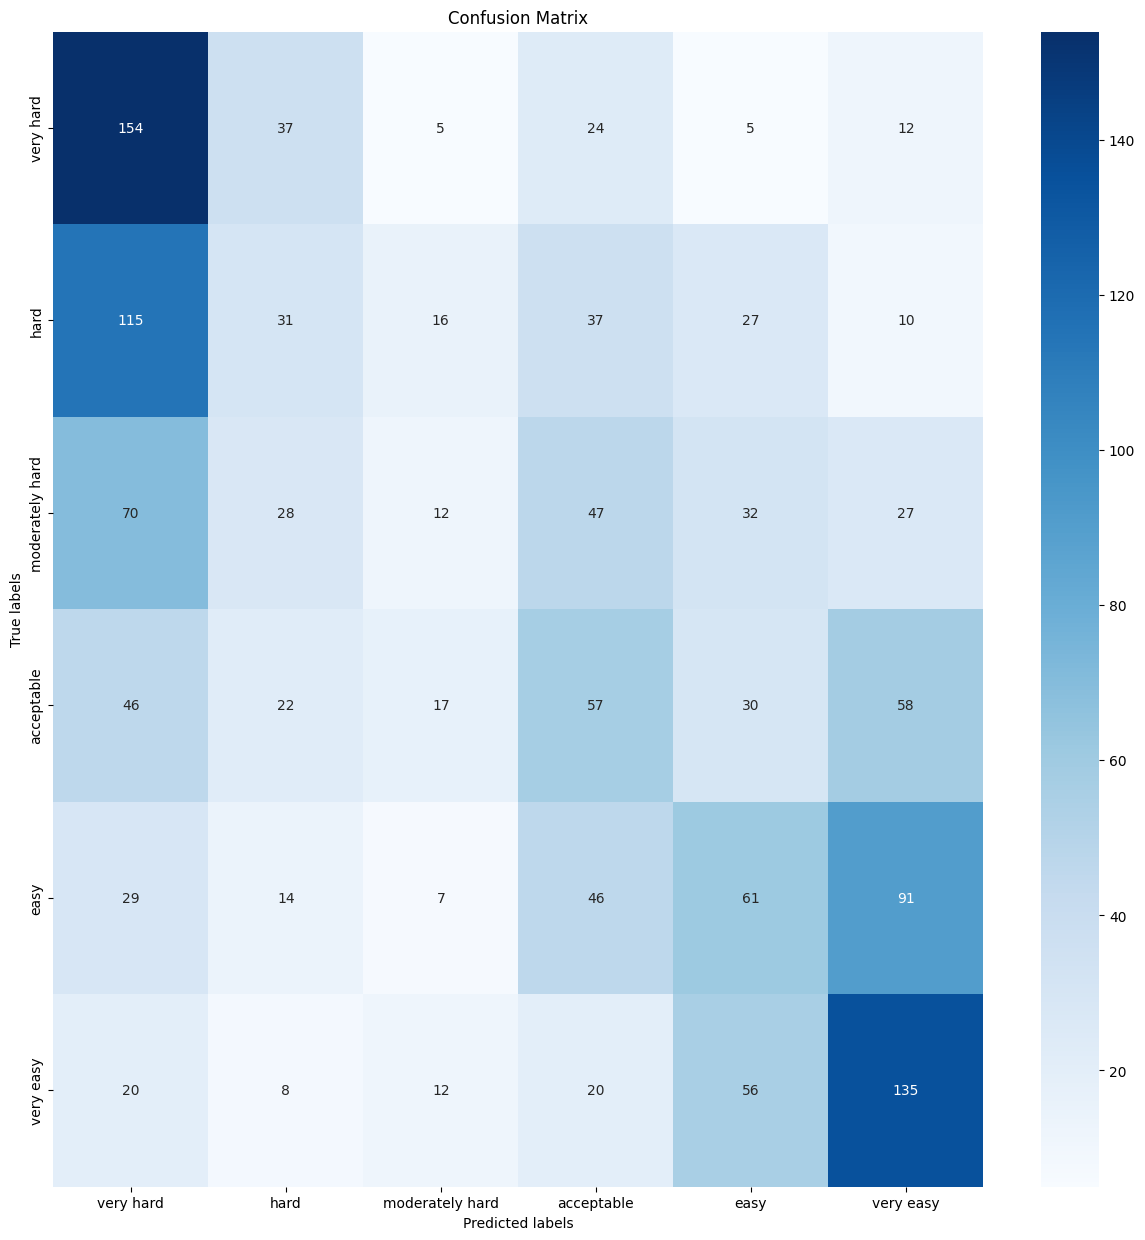

In [205]:
y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()


# 6. Model with numerical features

In [206]:
X_train_num = X_train.drop(columns=['Excerpt'])
X_test_num = X_test.drop(columns=['Excerpt'])


## 6.1 Preprocessing

### 6.1.1 Scaling

In [207]:
scaler = StandardScaler()
scaler.fit(X_train_num)
X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)


## 6.2 Model Training

In [217]:
def build_model_num():
    model = Sequential([
        layers.Dense(356, activation="relu", input_dim = X_train_num.shape[1]),
        layers.Dropout(0.25),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.25),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.25),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.15),
        layers.Dense(6, activation='softmax')
    ])

    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
    return model

model_num = build_model_num()
model_num.summary()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 356)               10680     
                                                                 
 dropout_52 (Dropout)        (None, 356)               0         
                                                                 
 dense_86 (Dense)            (None, 128)               45696     
                                                                 
 dropout_53 (Dropout)        (None, 128)               0         
                                                                 
 dense_87 (Dense)            (None, 64)                8256      
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 dense_88 (Dense)            (None, 32)              

In [218]:
es = EarlyStopping(patience=10, restore_best_weights=True)
model_num = build_model_num()
model_num.fit(X_train_num, y_train,
          validation_split=0.3,
          epochs=50,
          batch_size=32,
          callbacks=[es]
          )


Epoch 1/50
73/73 [==============================] - 0s 2ms/step - loss: 1.6894 - accuracy: 0.2537 - val_loss: 1.5649 - val_accuracy: 0.3347
Epoch 2/50
73/73 [==============================] - 0s 1ms/step - loss: 1.5642 - accuracy: 0.3064 - val_loss: 1.5166 - val_accuracy: 0.3377
Epoch 3/50
73/73 [==============================] - 0s 1ms/step - loss: 1.5267 - accuracy: 0.3280 - val_loss: 1.4903 - val_accuracy: 0.3538
Epoch 4/50
73/73 [==============================] - 0s 1ms/step - loss: 1.4935 - accuracy: 0.3652 - val_loss: 1.4858 - val_accuracy: 0.3589
Epoch 5/50
73/73 [==============================] - 0s 1ms/step - loss: 1.4893 - accuracy: 0.3526 - val_loss: 1.4754 - val_accuracy: 0.3478
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4742 - accuracy: 0.3660 - val_loss: 1.4777 - val_accuracy: 0.3649
Epoch 7/50
73/73 [==============================] - 0s 1ms/step - loss: 1.4598 - accuracy: 0.3587 - val_loss: 1.4758 - val_accuracy: 0.3548
Epoch 8/50
73/73 [==

## 6.3 Model Evaluation

In [219]:
loss, accuracy = model_nlp.evaluate(X_test_pad, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


45/45 [==============================] - 1s 14ms/step - loss: 1.5984 - accuracy: 0.3173
Test loss: 1.5984
Test accuracy: 0.3173


45/45 [==============================] - 0s 613us/step


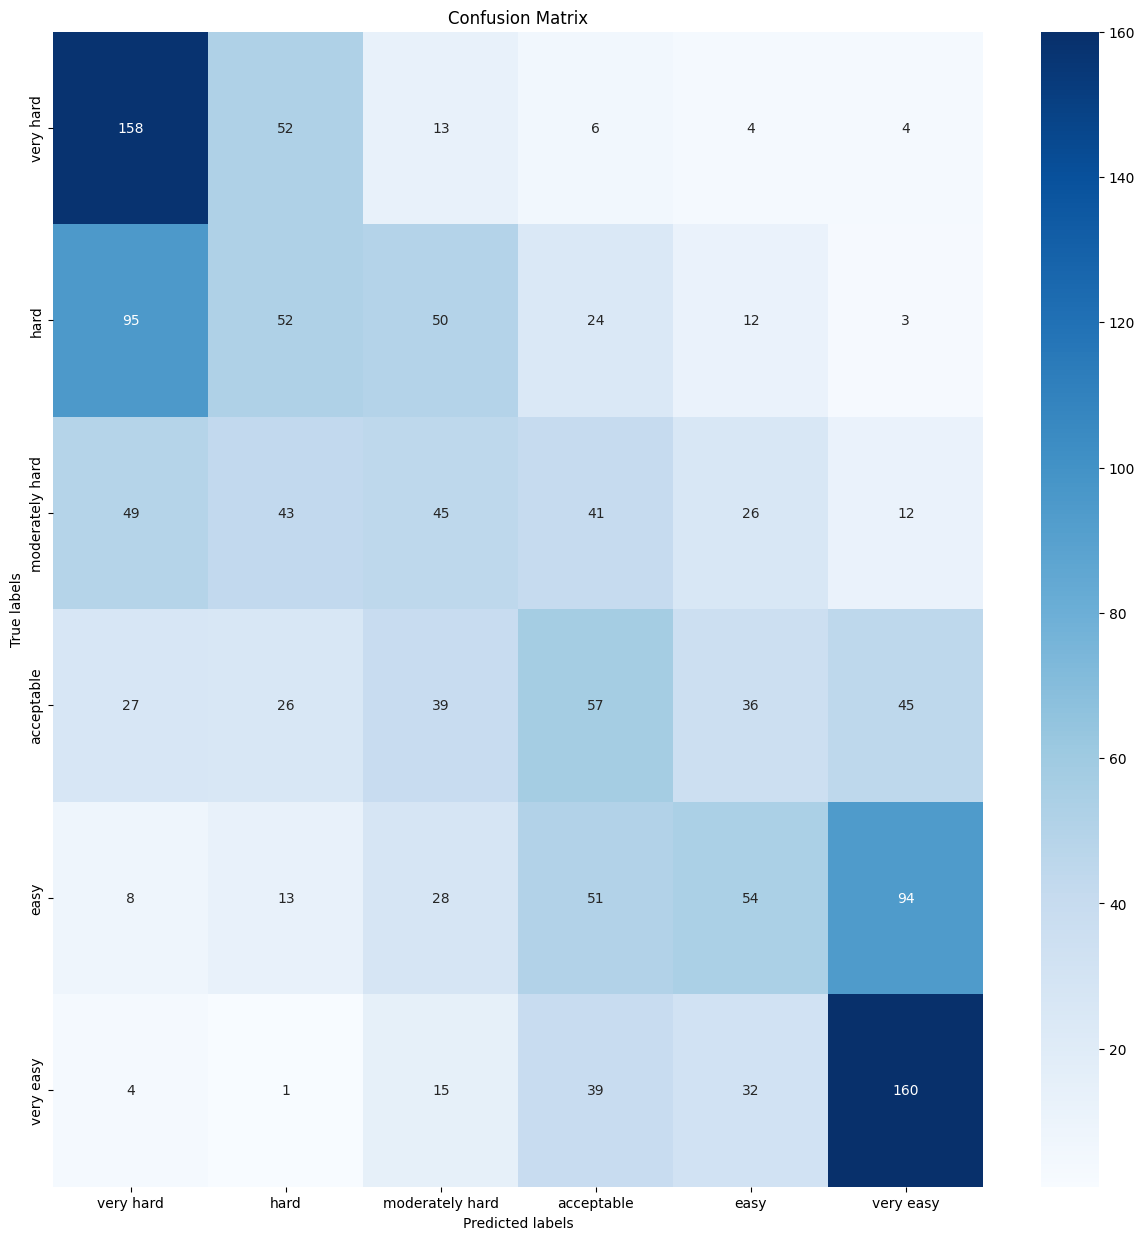

In [220]:
predictions = model_num.predict(X_test_num)

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)

y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()


# 7. Combining the models

In [227]:
# Define Inputs and Outputs of NLP model as with Numeric Model
model_nlp = build_model_nlp() # comment-out to keep pre-trained weights not to start from scratch
input_text = model_nlp.input
output_text = model_nlp.output

model_num = build_model_num() # comment-out to keep pre-trained weights not to start from scratch
input_num = model_num.input
output_num = model_num.output


In [228]:
# Let's combine the two streams of data and add two dense layers on top!
inputs = [input_text, input_num]

combined = layers.concatenate([output_text, output_num])

x = layers.Dense(32, activation="relu")(combined)
x = layers.Dropout(0.25)(x)
x = layers.Dense(16, activation="relu")(x)

outputs = layers.Dense(6, activation="softmax")(x)

model_combined = models.Model(inputs=inputs, outputs=outputs)


In [229]:
model_combined.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
es = EarlyStopping(patience=10, restore_best_weights=True)

model_combined.fit(x=[X_train_pad, X_train_num],
                   y=y_train,
                   validation_split=0.3,
                   epochs=100,
                   batch_size=32,
                   callbacks=[es])


Epoch 1/100
73/73 [==============================] - 4s 45ms/step - loss: 1.7527 - accuracy: 0.2446 - val_loss: 1.6554 - val_accuracy: 0.3145
Epoch 2/100
73/73 [==============================] - 3s 42ms/step - loss: 1.6114 - accuracy: 0.3111 - val_loss: 1.5559 - val_accuracy: 0.3256
Epoch 3/100
73/73 [==============================] - 3s 42ms/step - loss: 1.5534 - accuracy: 0.3250 - val_loss: 1.5092 - val_accuracy: 0.3357
Epoch 4/100
73/73 [==============================] - 3s 41ms/step - loss: 1.5162 - accuracy: 0.3440 - val_loss: 1.4973 - val_accuracy: 0.3448
Epoch 5/100
73/73 [==============================] - 3s 42ms/step - loss: 1.4996 - accuracy: 0.3431 - val_loss: 1.4850 - val_accuracy: 0.3569
Epoch 6/100
73/73 [==============================] - 3s 42ms/step - loss: 1.4822 - accuracy: 0.3561 - val_loss: 1.4617 - val_accuracy: 0.3690
Epoch 7/100
73/73 [==============================] - 3s 41ms/step - loss: 1.4760 - accuracy: 0.3621 - val_loss: 1.4672 - val_accuracy: 0.3740
Epoch 

In [224]:
loss, accuracy = model_combined.evaluate([X_test_pad, X_test_num], y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


45/45 [==============================] - 1s 13ms/step - loss: 1.4621 - accuracy: 0.3639
Test loss: 1.4621
Test accuracy: 0.3639


In [225]:
predictions = model_combined.predict([X_test_pad, X_test_num])

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)


45/45 [==============================] - 1s 12ms/step


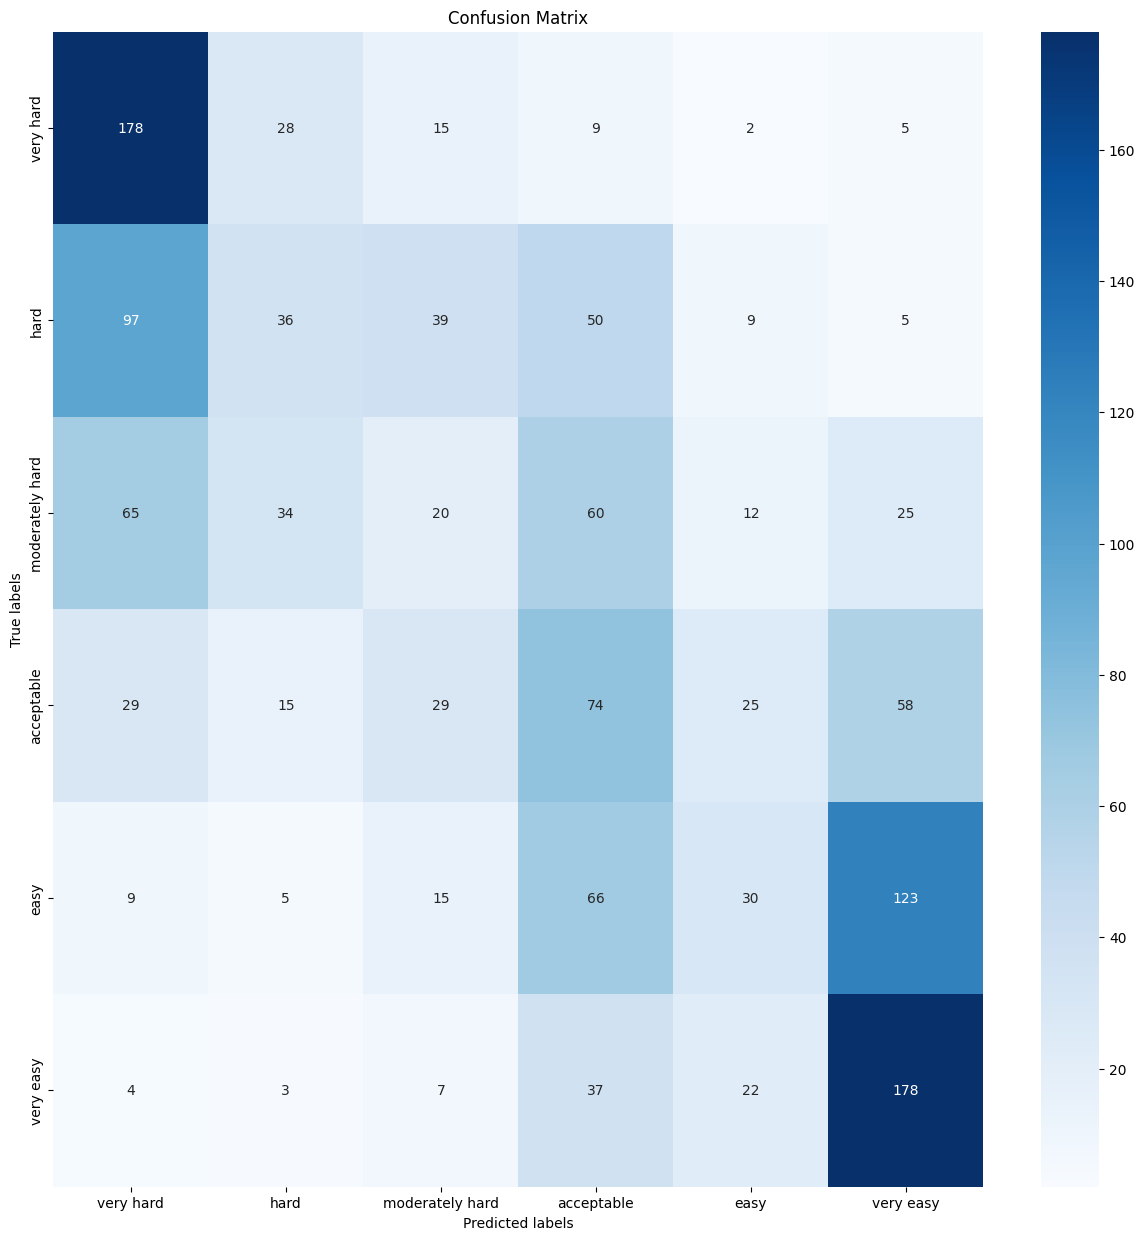

In [226]:
y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()
